##### Importando Bibliotecas


In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, auc
from sklearn.linear_model import LogisticRegression

##### Funções Auxiliares


In [ ]:
# Metadados referente ao conjunto de dados
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

def custom_fillna(df):
    import pandas as pd
    import numpy as np

    numerical_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    means = {}

    for col in numerical_cols:
        if col != 'class':  # Verifica se a coluna não é 'class'
            means[col] = df[col].mean()
            df[col].fillna(means[col], inplace=True)

    return df, means


def custom_fillna_prod(df, means):
    import numpy as np
    import pandas as pd

    for col, mean_value in means.items():
      df[col].fillna(mean_value, inplace=True)

    return df

# Ajustar configurações de exibição do pandas para evitar notação científica
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Definir a opção para exibir todas as colunas
pd.set_option('display.max_columns', None)

# Definir a opção para exibir todas as linhas
pd.set_option('display.max_rows', None)

##### Leitura dos Dados


In [ ]:
df_train = pd.read_csv('air_system_previous_years.csv')
df_test = pd.read_csv('air_system_present_year.csv')

##### Tratameto Inicial da base


In [ ]:
# Substituir 'na' por NaN
df_train.replace('na', np.nan, inplace=True)
df_test.replace('na', np.nan, inplace=True)

In [ ]:
def convert_columns_to_float(df, ignore_column='class'):
    for column in df.columns:
        if column == ignore_column:
            continue
        df[column] = df[column].astype(float)
    return df

# Converter colunas para float
df_train_01 = convert_columns_to_float(df_train)
df_validation = convert_columns_to_float(df_test)

In [ ]:
# Transformar 'neg' para 0 e 'pos' para 1
df_train_01['class'] = df_train_01['class'].replace({'neg': 0, 'pos': 1})
df_validation['class'] = df_validation['class'].replace({'neg': 0, 'pos': 1})


##### Tratamento da base


In [ ]:
abt_01, abt_01_test = train_test_split(df_train_01, test_size=0.3, random_state=13)

In [ ]:
metadata_df = generate_metadata(abt_01)

In [ ]:
metadata_df

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,br_000,float64,34466,82,2870
1,bq_000,float64,34087,81,3215
2,bp_000,float64,33396,80,3767
3,ab_000,float64,32437,77,24
4,cr_000,float64,32437,77,56
5,bo_000,float64,32415,77,4515
6,bn_000,float64,30772,73,5590
7,bm_000,float64,27651,66,7291
8,bl_000,float64,19048,45,10221
9,bk_000,float64,16123,38,11140


##### Cutoff de Nulos



In [ ]:
missing_cutoff = 60
df_drop_missing = metadata_df[(metadata_df['percent_nulos'] >= missing_cutoff)]
list_drop_missing = list(df_drop_missing.nome_variavel.values)
list_drop_missing

['br_000',
 'bq_000',
 'bp_000',
 'ab_000',
 'cr_000',
 'bo_000',
 'bn_000',
 'bm_000']

In [ ]:
# retirando lista de variáveis com alto percentual de nulos
abt_02 = abt_01.drop(axis=1,columns=list_drop_missing)
abt_02_test = abt_01_test.drop(axis=1,columns=list_drop_missing)
df_validation_01 = df_validation.drop(axis=1,columns=list_drop_missing)

abt_02.shape, abt_02_test.shape, df_validation_01.shape

((42000, 163), (18000, 163), (16000, 163))

##### Tratamento dos valores nulos



In [ ]:
abt_03, means = custom_fillna(abt_02)
means

{'aa_000': 59514.002095238095,
 'ac_000': 354947711.97530365,
 'ad_000': 272466.82924047025,
 'ae_000': 6.48460122394149,
 'af_000': 10.673615602766306,
 'ag_000': 170.01497460095817,
 'ag_001': 957.6014156053639,
 'ag_002': 8497.247273515179,
 'ag_003': 87594.38076895298,
 'ag_004': 435420.6345667718,
 'ag_005': 1113559.7424946434,
 'ag_006': 1668979.03512531,
 'ag_007': 500796.1512868045,
 'ag_008': 34780.73852228134,
 'ag_009': 4975.882851433662,
 'ah_000': 1815174.4951119672,
 'ai_000': 9220.448194511315,
 'aj_000': 1341.012469908522,
 'ak_000': 1222.6525151164287,
 'al_000': 57694.908985842245,
 'am_0': 91273.0911892152,
 'an_000': 3477134.300539343,
 'ao_000': 3013413.564221618,
 'ap_000': 1008051.9598381971,
 'aq_000': 446230.2016022325,
 'ar_000': 0.5092897812406353,
 'as_000': 142.3300914780934,
 'at_000': 4512.01020702937,
 'au_000': 238.4363023591719,
 'av_000': 1097.2673947113112,
 'ax_000': 374.5229115876412,
 'ay_000': 11850.38280046225,
 'ay_001': 11570.872929506933,
 'a

In [ ]:
abt_03_test = custom_fillna_prod(abt_02_test, means)
df_validation_02 = custom_fillna_prod(df_validation_01, means)

##### Feature Selection


In [ ]:
# Remover a coluna 'class' de `abt_03` para obter X
X = abt_03.drop(columns='class')

# Atribuir a coluna 'class' a y
y = abt_03['class']

# Treinar o modelo com o algoritmo Random Forest
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

Número de features selecionadas:  31


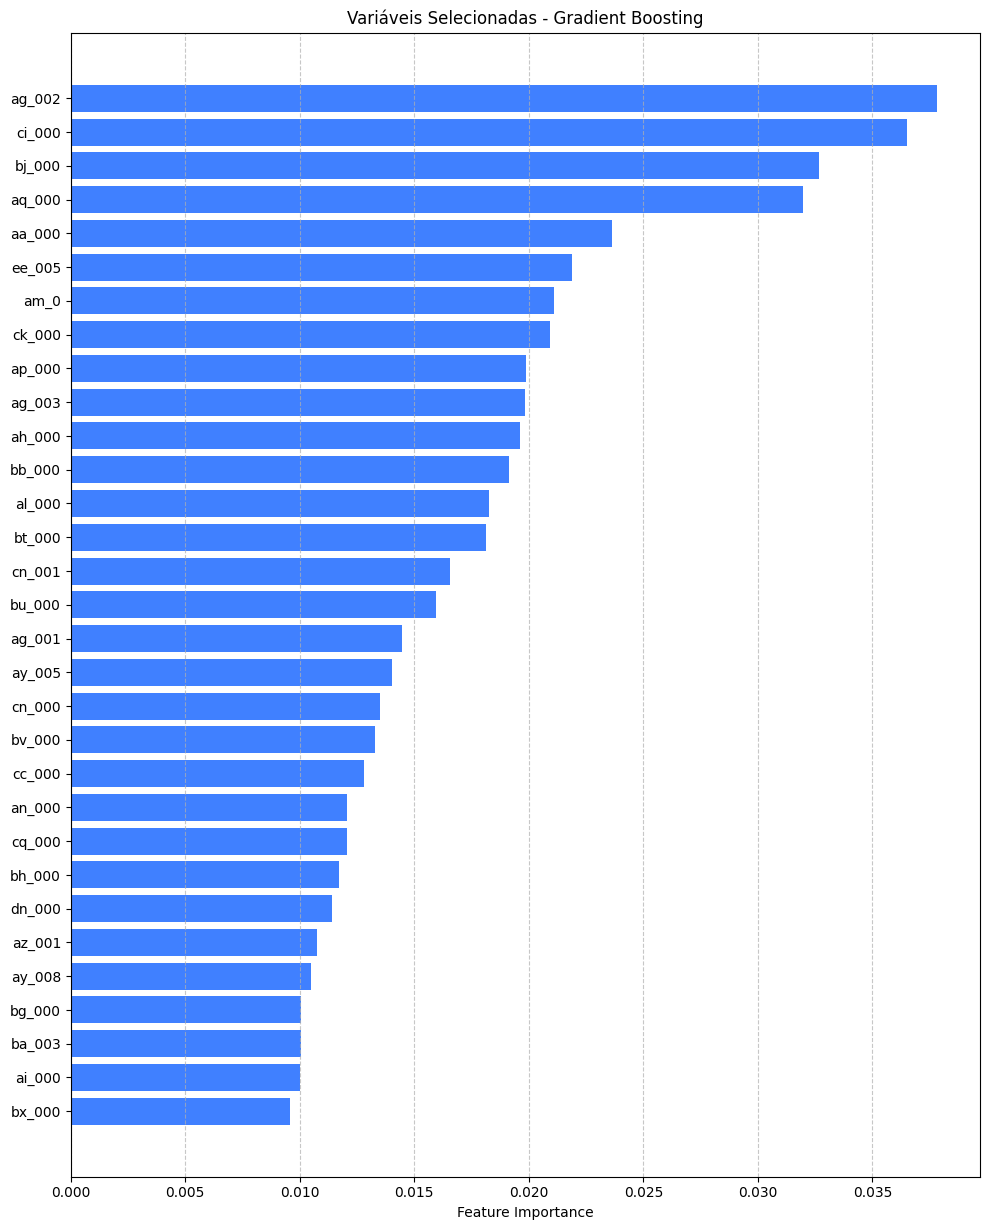

In [ ]:
# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.25

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ',len(selected_features))

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Gradient Boosting")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
list(selected_features_df.Feature)

['bx_000',
 'ai_000',
 'ba_003',
 'bg_000',
 'ay_008',
 'az_001',
 'dn_000',
 'bh_000',
 'cq_000',
 'an_000',
 'cc_000',
 'bv_000',
 'cn_000',
 'ay_005',
 'ag_001',
 'bu_000',
 'cn_001',
 'bt_000',
 'al_000',
 'bb_000',
 'ah_000',
 'ag_003',
 'ap_000',
 'ck_000',
 'am_0',
 'ee_005',
 'aa_000',
 'aq_000',
 'bj_000',
 'ci_000',
 'ag_002']

##### Salvando DataFrame após feature selection


In [ ]:
abt_train_fs00 = abt_03[list(selected_features_df.Feature)+['class']]
abt_test_fs00 = abt_03_test[list(selected_features_df.Feature)+['class']]
df_validation_fs00 = df_validation_02[list(selected_features_df.Feature)+['class']]

In [ ]:
abt_train_fs00.to_csv('abt_train_fs00.csv', index=False)
abt_test_fs00.to_csv('abt_test_fs01.csv', index=False)
df_validation_fs00.to_csv('abt_val_fs01.csv', index=False)